#1.Librerías

In [1]:
pip install xgboost lightgbm

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier,
    AdaBoostClassifier, BaggingClassifier
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# XGBoost y LightGBM
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

#2.Carga de datos y preprocesamiento

In [103]:
# Cargar el dataset
df = pd.read_csv("large_transacciones_balanceadas_procesadas.csv")

In [107]:
df.head()

,Transaction Amount,Payment Method,Product Category,Quantity,Customer Age,Device Used,Is Fraudulent,Account Age Days,Address Match,Transaction Hour_sin,Transaction Hour_cos,Day_sin,Day_cos,Dof_sin,Dof_cos,Month_sin,Month_cos
0,3.468233,PayPal,clothing,2,32,tablet,True,147,1,-0.258819,-0.965926,-0.299363,-0.954139,0.974928,-0.222521,0.000000,1.0
1,6.733759,bank transfer,health & beauty,2,36,mobile,True,65,1,0.258819,0.965926,-0.651372,-0.758758,0.781831,0.623490,0.866025,0.5
2,5.940171,debit card,home & garden,4,37,desktop,True,30,1,-0.866025,0.500000,0.897805,-0.440394,0.974928,-0.222521,0.000000,1.0
3,3.855664,credit card,clothing,2,30,tablet,True,12,1,0.500000,-0.866025,0.937752,0.347305,-0.974928,-0.222521,0.000000,1.0
4,7.620215,credit card,health & beauty,1,32,mobile,True,9,0,-0.965926,-0.258819,-0.201299,0.979530,0.781831,0.623490,0.000000,1.0


In [58]:
df.shape

(295352, 13)

In [105]:
# Codificación cíclica de variables temporales
df['Transaction Hour_sin'] = np.sin(2 * np.pi * df['Transaction Hour'] / 24)
df['Transaction Hour_cos'] = np.cos(2 * np.pi * df['Transaction Hour'] / 24)

df['Day_sin'] = np.sin(2 * np.pi * df['Day'] / 31)
df['Day_cos'] = np.cos(2 * np.pi * df['Day'] / 31)

df['Dof_sin'] = np.sin(2 * np.pi * df['Day of the week'] / 7)
df['Dof_cos'] = np.cos(2 * np.pi * df['Day of the week'] / 7)

df['Month_sin'] = np.sin(2 * np.pi * (df['Month'] - 1) / 12)
df['Month_cos'] = np.cos(2 * np.pi * (df['Month'] - 1) / 12)

# Conversión AdressMatch a Entero
df['Address Match'] = df['Address Match'].astype(int)

# Transformación logarítmica
df['Transaction Amount'] = np.log1p(df['Transaction Amount'])

# Eliminar columnas temporales originales
temporal_cols = ["Transaction Hour", "Day of the week", "Month", "Day"]
df.drop(columns=temporal_cols, inplace=True)

# Separar variables
X = df.drop("Is Fraudulent", axis=1)
y = df["Is Fraudulent"].astype(int)

# Identificar columnas categóricas y cíclicas
categorical_cols = ["Payment Method", "Product Category", "Device Used"]
cyclic_cols = [col for col in df.columns if any(key in col for key in ["_sin", "_cos"])]

# Variables numéricas: solo las que no son categóricas ni cíclicas
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
numeric_cols = [
    col for col in numeric_cols
    if col not in categorical_cols + cyclic_cols
]

# División en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Preprocesamiento
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(sparse_output=False), categorical_cols)
    ],
    remainder='passthrough'  # deja pasar columnas como las cíclicas sin transformar
)

# Ajustar y transformar solo una vez
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [108]:
# Obtener nombres de columnas procesadas
num_features = numeric_cols

# Obtener nombres de columnas one-hot codificadas
cat_features = preprocessor.named_transformers_["cat"].get_feature_names_out(categorical_cols)

# Columnas que pasaron sin transformación (cíclicas)
passthrough_features = [col for col in X_train.columns if col not in numeric_cols + categorical_cols]

# Combinar todos los nombres de columnas
feature_names = list(num_features) + list(cat_features) + passthrough_features

# Convertir X_train_processed a DataFrame
X_train_df = pd.DataFrame(X_train_processed, columns=feature_names, index=X_train.index)

# Mostrar las primeras filas
X_train_df.head()

,Transaction Amount,Quantity,Customer Age,Account Age Days,Address Match,Payment Method_PayPal,Payment Method_bank transfer,Payment Method_credit card,Payment Method_debit card,Product Category_clothing,...,Device Used_mobile,Device Used_tablet,Transaction Hour_sin,Transaction Hour_cos,Day_sin,Day_cos,Dof_sin,Dof_cos,Month_sin,Month_cos
274478,-0.646281,1.412852,0.323916,1.454090,0.332784,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.866025,-0.500000,0.394356,0.918958,0.781831,0.623490,1.000000,6.123234e-17
99197,0.343337,-0.704437,-1.052531,1.168324,0.332784,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.258819,-0.965926,-0.897805,-0.440394,0.974928,-0.222521,0.500000,8.660254e-01
91864,0.484134,-1.410200,-0.311367,1.382649,0.332784,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,-0.866025,0.500000,-0.848644,0.528964,-0.433884,-0.900969,0.000000,1.000000e+00
271781,-1.780266,-0.704437,-1.264293,-1.403577,0.332784,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,-0.500000,-0.866025,0.571268,0.820763,-0.781831,0.623490,0.866025,5.000000e-01
245519,-0.241259,1.412852,1.382722,-1.358926,0.332784,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,-0.500000,-0.866025,-0.968077,-0.250653,-0.433884,-0.900969,0.866025,5.000000e-01


In [122]:
X_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 236281 entries, 274478 to 79353
Data columns (total 25 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Transaction Amount                236281 non-null  float64
 1   Quantity                          236281 non-null  float64
 2   Customer Age                      236281 non-null  float64
 3   Account Age Days                  236281 non-null  float64
 4   Address Match                     236281 non-null  float64
 5   Payment Method_PayPal             236281 non-null  float64
 6   Payment Method_bank transfer      236281 non-null  float64
 7   Payment Method_credit card        236281 non-null  float64
 8   Payment Method_debit card         236281 non-null  float64
 9   Product Category_clothing         236281 non-null  float64
 10  Product Category_electronics      236281 non-null  float64
 11  Product Category_health & beauty  236281 non-null  fl

In [120]:
X_train_processed.shape, X_test_processed.shape

((236281, 25), (59071, 25))

#3.Modelos

## Sin class_weight='balanced'

In [123]:
models = {
    "Regresión Logística": LogisticRegression(max_iter=1000, C=1.0, penalty='l2', solver='liblinear', class_weight='balanced'),
    "Árbol de Decisión": DecisionTreeClassifier(max_depth=6, min_samples_split=10),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=8, min_samples_split=10),
    "Naive Bayes": GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, learning_rate=0.5),
    "Bagging": BaggingClassifier(n_estimators=50, max_samples=0.8, max_features=0.8),
    "XGBoost": XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, eval_metric="logloss"),
    "LightGBM": LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=4)
}

# Diccionarios de resultados
results = {}
confusion_matrices = {}
predicciones = pd.DataFrame(index=y_test.index)
predicciones["Real"] = y_test.values
probabilidades = pd.DataFrame(index=y_test.index)
fpr_dict = {}

# Entrenamiento y evaluación
for name, model in models.items():
    model.fit(X_train_processed, y_train)
    y_pred = model.predict(X_test_processed)
    predicciones[name] = y_pred

    try:
        y_prob = model.predict_proba(X_test_processed)[:, 1]
        probabilidades[name] = y_prob
        auc = roc_auc_score(y_test, y_prob)
    except:
        probabilidades[name] = None
        auc = "-"

    report = classification_report(y_test, y_pred, output_dict=True)

    results[name] = {
        "Accuracy": report["accuracy"],
        "Precision fraude": report["1"]["precision"],
        "Precision legitimo": report["0"]["precision"],
        "Recall fraude": report["1"]["recall"],
        "Recall legitimo": report["0"]["recall"],
        "F1-score fraude": report["1"]["f1-score"],
        "F1-score legitimo": report["0"]["f1-score"],
        "ROC AUC": auc
    }

    confusion_matrices[name] = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fpr = fp / (fp + tn)
    fpr_dict[name] = round(fpr, 4)


[LightGBM] [Info] Number of positive: 59070, number of negative: 177211
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 720
[LightGBM] [Info] Number of data points in the train set: 236281, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.249999 -> initscore=-1.098618
[LightGBM] [Info] Start training from score -1.098618
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

In [124]:
# Mostrar resumen de métricas
results_df = pd.DataFrame(results).T.round(3)
results_df['FP-Rate'] = pd.DataFrame.from_dict(fpr_dict, orient="index", columns=["FPR"])
print(results_df)

                     Accuracy  Precision fraude  Precision legitimo  \
Regresión Logística     0.687             0.422               0.866   
Árbol de Decisión       0.827             0.783               0.834   
Random Forest           0.827             0.811               0.829   
Naive Bayes             0.801             0.737               0.808   
Gradient Boosting       0.828             0.775               0.836   
AdaBoost                0.825             0.757               0.837   
Bagging                 0.822             0.767               0.831   
XGBoost                 0.828             0.788               0.834   
LightGBM                0.828             0.786               0.834   

                     Recall fraude  Recall legitimo  F1-score fraude  \
Regresión Logística          0.680            0.690            0.521   
Árbol de Decisión            0.428            0.960            0.554   
Random Forest                0.400            0.969            0.535   
N

In [125]:
# Guardar predicciones y probabilidades en Excel
with pd.ExcelWriter("resultados_modelos.xlsx") as writer:
    results_df.to_excel(writer, sheet_name="Resumen métricas")
    predicciones.to_excel(writer, sheet_name="Predicciones")
    probabilidades.to_excel(writer, sheet_name="Probabilidades")

print("Archivo 'resultados_modelos.xlsx' guardado con éxito.")

Archivo 'resultados_modelos.xlsx' guardado con éxito.


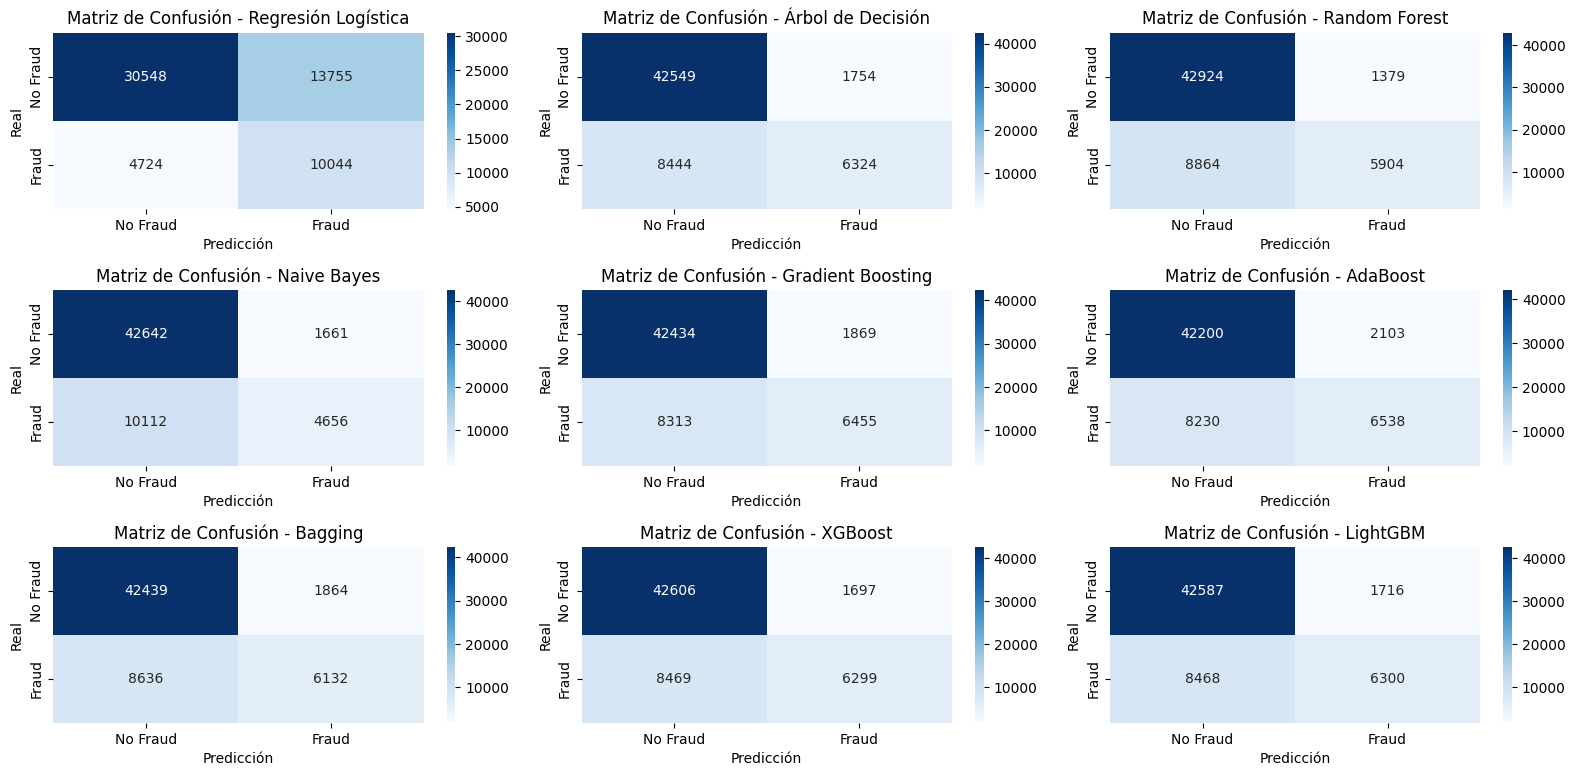

In [126]:
# Visualización de matrices de confusión
labels = ["No Fraud", "Fraud"]
plt.figure(figsize=(16, 10))

for i, (name, cm) in enumerate(confusion_matrices.items(), 1):
    plt.subplot(4, 3, i)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title(f"Matriz de Confusión - {name}")
    plt.xlabel("Predicción")
    plt.ylabel("Real")

plt.tight_layout()
plt.show()

## Con class_weight='balanced'

In [127]:
y.value_counts()

,count
Is Fraudulent,
0,221514
1,73838


In [128]:
# Para el XGBoost
n_neg = (y_train == 0).sum()  # Transacciones legítimas
n_pos = (y_train == 1).sum()  # Transacciones fraudulentas

scale_pos_weight = n_neg / n_pos

In [129]:
# Para el Gradient Boosting
sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)

In [130]:
models_balanced = {
    "Regresión Logística": LogisticRegression(max_iter=1000, C=1.0, penalty='l2', class_weight='balanced'),
    "Árbol de Decisión": DecisionTreeClassifier(max_depth=6, min_samples_split=10, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=8, min_samples_split=10,class_weight='balanced'),
    "XGBoost": XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, eval_metric="logloss", scale_pos_weight=scale_pos_weight),
    "LightGBM": LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=4, class_weight='balanced')
}

# Diccionarios de resultados
results_bal = {}
confusion_matrices_bal = {}
predicciones_bal = pd.DataFrame(index=y_test.index)
predicciones_bal["Real"] = y_test.values
probabilidades_bal = pd.DataFrame(index=y_test.index)
fpr_dict_bal = {}

# Entrenamiento y evaluación
for name, model in models_balanced.items():
    if name == "Gradient Boosting":
        model.fit(X_train_processed, y_train, sample_weight=sample_weights)
    else:
        model.fit(X_train_processed, y_train)

    y_pred = model.predict(X_test_processed)
    predicciones_bal[name] = y_pred

    try:
        y_prob = model.predict_proba(X_test_processed)[:, 1]
        probabilidades_bal[name] = y_prob
        auc = roc_auc_score(y_test, y_prob)
    except:
        probabilidades_bal[name] = None
        auc = "-"

    report = classification_report(y_test, y_pred, output_dict=True)

    results_bal[name] = {
        "Accuracy": report["accuracy"],
        "Precision fraude": report["1"]["precision"],
        "Precision legitimo": report["0"]["precision"],
        "Recall fraude": report["1"]["recall"],
        "Recall legitimo": report["0"]["recall"],
        "F1-score fraude": report["1"]["f1-score"],
        "F1-score legitimo": report["0"]["f1-score"],
        "ROC AUC": auc
    }

    confusion_matrices_bal[name] = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fpr = fp / (fp + tn)
    fpr_dict_bal[name] = round(fpr, 4)

[LightGBM] [Info] Number of positive: 59070, number of negative: 177211
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010728 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 720
[LightGBM] [Info] Number of data points in the train set: 236281, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

In [131]:
# Mostrar resumen de métricas
results_bal_df = pd.DataFrame(results_bal).T.round(3)
results_bal_df['FP-Rate'] = pd.DataFrame.from_dict(fpr_dict_bal, orient="index", columns=["FPR"])
print(results_bal_df)

                     Accuracy  Precision fraude  Precision legitimo  \
Regresión Logística     0.687             0.422               0.866   
Árbol de Decisión       0.740             0.487               0.899   
Random Forest           0.780             0.548               0.881   
XGBoost                 0.767             0.526               0.887   
LightGBM                0.766             0.524               0.887   

                     Recall fraude  Recall legitimo  F1-score fraude  \
Regresión Logística          0.680            0.689            0.521   
Árbol de Decisión            0.752            0.736            0.591   
Random Forest                0.670            0.816            0.603   
XGBoost                      0.697            0.790            0.599   
LightGBM                     0.698            0.788            0.598   

                     F1-score legitimo  ROC AUC  FP-Rate  
Regresión Logística              0.768    0.752   0.3106  
Árbol de Decisión     

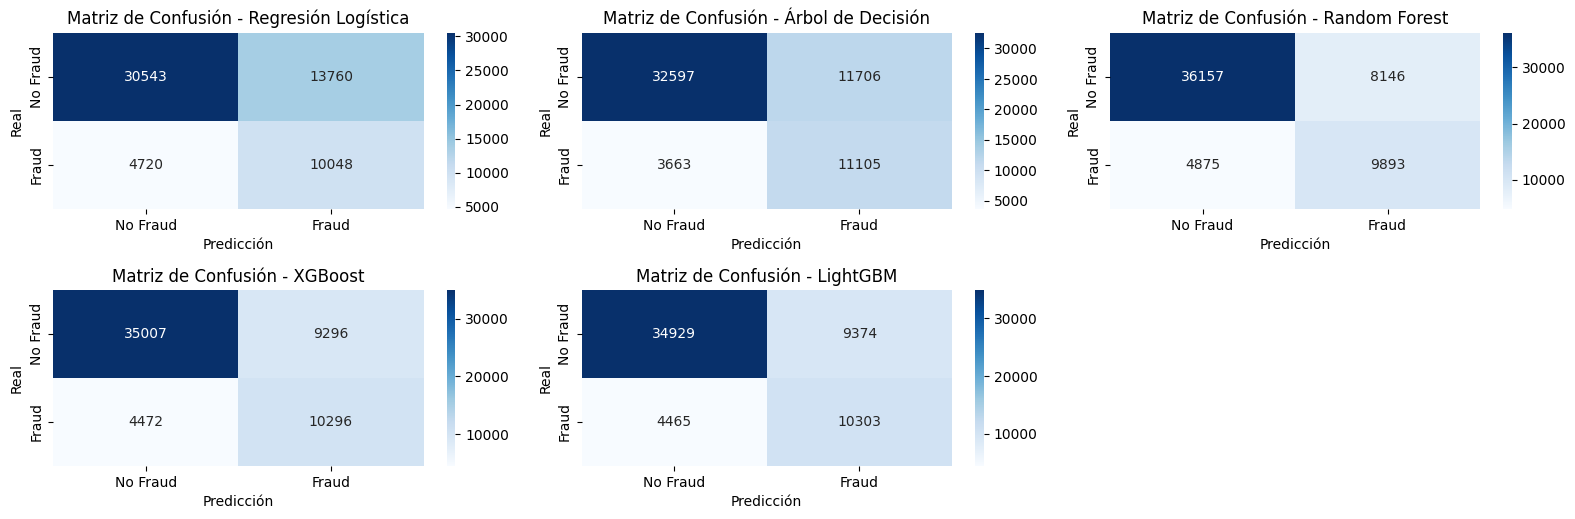

In [132]:
# Visualización de matrices de confusión
labels = ["No Fraud", "Fraud"]
plt.figure(figsize=(16, 10))

for i, (name, cm) in enumerate(confusion_matrices_bal.items(), 1):
    plt.subplot(4, 3, i)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title(f"Matriz de Confusión - {name}")
    plt.xlabel("Predicción")
    plt.ylabel("Real")

plt.tight_layout()
plt.show()

In [133]:
# Guardar predicciones y probabilidades en Excel
with pd.ExcelWriter("resultados_modelos_weight_class.xlsx") as writer:
    results_bal_df.to_excel(writer, sheet_name="Resumen métricas_bal")
    predicciones_bal.to_excel(writer, sheet_name="Predicciones_bal")
    probabilidades_bal.to_excel(writer, sheet_name="Probabilidades_bal")

## SMOTE

In [134]:
X_train_processed.shape

(236281, 25)

In [135]:
# Aplicar SMOTE sobre los datos ya transformados (solo entrenamiento)
smote = SMOTE(random_state=42, sampling_strategy='minority')
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

# Revisión rápida
print("Antes de SMOTE:", y_train.value_counts().to_dict())
print("Después de SMOTE:", pd.Series(y_train_resampled).value_counts().to_dict())

Antes de SMOTE: {0: 177211, 1: 59070}
Después de SMOTE: {0: 177211, 1: 177211}


In [136]:
models_smote = {
    "Regresión Logística": LogisticRegression(max_iter=1000, C=1.0, penalty='l2', solver='liblinear', class_weight='balanced'),
    "Árbol de Decisión": DecisionTreeClassifier(max_depth=6, min_samples_split=10),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=8, min_samples_split=10),
    "Naive Bayes": GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, learning_rate=0.5),
    "Bagging": BaggingClassifier(n_estimators=50, max_samples=0.8, max_features=0.8),
    "XGBoost": XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, eval_metric="logloss"),
    "LightGBM": LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=4)
}

# Diccionarios de resultados
results_smote = {}
confusion_matrices_smote = {}
predicciones_smote = pd.DataFrame(index=y_test.index)
predicciones_smote["Real"] = y_test.values
probabilidades_smote = pd.DataFrame(index=y_test.index)
fpr_dict_smote = {}

# Entrenamiento y evaluación
for name, model in models_smote.items():
    # Entrenar con los datos balanceados por SMOTE
    model.fit(X_train_resampled, y_train_resampled)

    # Predecir sobre el conjunto de prueba original
    y_pred = model.predict(X_test_processed)
    predicciones_smote[name] = y_pred

    # Calcular probabilidades (si están disponibles)
    try:
        y_prob = model.predict_proba(X_test_processed)[:, 1]
        probabilidades_smote[name] = y_prob
        auc = roc_auc_score(y_test, y_prob)
    except:
        probabilidades_smote[name] = None
        auc = "-"

    # Generar reporte de métricas
    report = classification_report(y_test, y_pred, output_dict=True)

    results_smote[name] = {
        "Accuracy": report["accuracy"],
        "Precision fraude": report["1"]["precision"],
        "Precision legitimo": report["0"]["precision"],
        "Recall fraude": report["1"]["recall"],
        "Recall legitimo": report["0"]["recall"],
        "F1-score fraude": report["1"]["f1-score"],
        "F1-score legitimo": report["0"]["f1-score"],
        "ROC AUC": auc
    }

    # Matriz de confusión y FPR
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices_smote[name] = cm
    tn, fp, fn, tp = cm.ravel()
    fpr = fp / (fp + tn)
    fpr_dict_smote[name] = round(fpr, 4)

[LightGBM] [Info] Number of positive: 177211, number of negative: 177211
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.115484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6123
[LightGBM] [Info] Number of data points in the train set: 354422, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

In [137]:
# Mostrar resumen de métricas
results_smote_df = pd.DataFrame(results_smote).T.round(3)
results_smote_df['FP-Rate'] = pd.DataFrame.from_dict(fpr_dict_smote, orient="index", columns=["FPR"])
print(results_smote_df)

                     Accuracy  Precision fraude  Precision legitimo  \
Regresión Logística     0.690             0.424               0.865   
Árbol de Decisión       0.727             0.471               0.891   
Random Forest           0.808             0.620               0.867   
Naive Bayes             0.709             0.445               0.867   
Gradient Boosting       0.816             0.655               0.860   
AdaBoost                0.803             0.607               0.868   
Bagging                 0.820             0.727               0.838   
XGBoost                 0.820             0.682               0.853   
LightGBM                0.821             0.688               0.851   

                     Recall fraude  Recall legitimo  F1-score fraude  \
Regresión Logística          0.676            0.694            0.521   
Árbol de Decisión            0.733            0.725            0.573   
Random Forest                0.595            0.879            0.607   
N

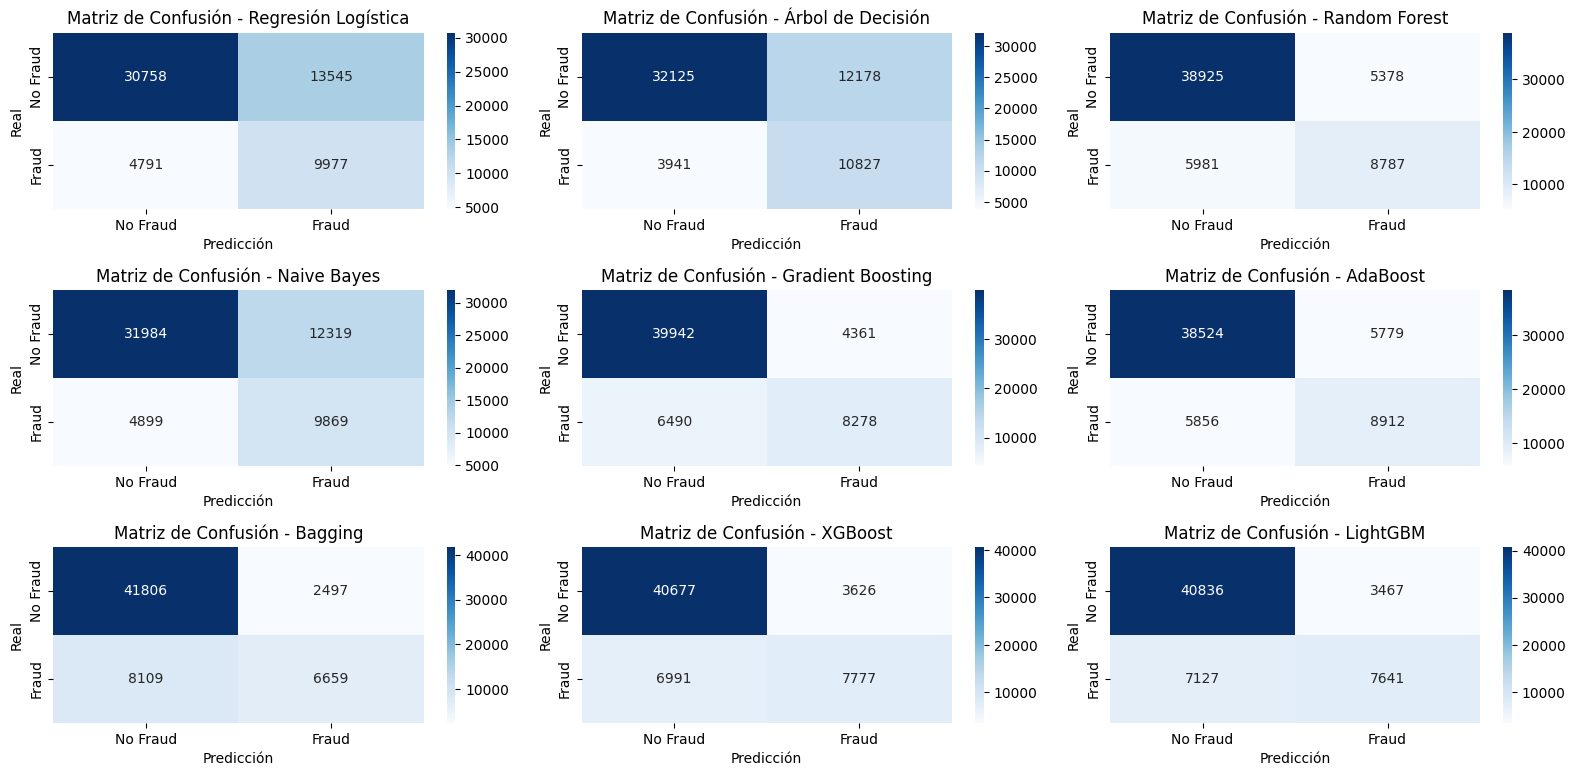

In [138]:
# Visualización de matrices de confusión
labels = ["No Fraud", "Fraud"]
plt.figure(figsize=(16, 10))

for i, (name, cm) in enumerate(confusion_matrices_smote.items(), 1):
    plt.subplot(4, 3, i)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title(f"Matriz de Confusión - {name}")
    plt.xlabel("Predicción")
    plt.ylabel("Real")

plt.tight_layout()
plt.show()

In [139]:
# Guardar predicciones y probabilidades en Excel
with pd.ExcelWriter("resultados_modelos_smote.xlsx") as writer:
    results_smote_df.to_excel(writer, sheet_name="Resumen métricas_smote")
    predicciones_smote.to_excel(writer, sheet_name="Predicciones_smote")
    probabilidades_smote.to_excel(writer, sheet_name="Probabilidades_smote")

print("Archivo 'resultados_modelos_smote.xlsx' guardado con éxito.")

Archivo 'resultados_modelos_smote.xlsx' guardado con éxito.


## Red neuronal

In [113]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

nn = Sequential([
    Dense(64, input_dim=X_train_processed.shape[1], activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # Para clasificación binaria
])

nn.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'AUC']
)

In [114]:
history = nn.fit(
    X_train_processed, y_train,
    validation_data=(X_test_processed, y_test),
    epochs=20,
    batch_size=64,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True)
    ],
    verbose=1
)

Epoch 1/20
3692/3692 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - AUC: 0.7214 - accuracy: 0.7762 - loss: 0.4980 - val_AUC: 0.8038 - val_accuracy: 0.8195 - val_loss: 0.4255
Epoch 2/20
3692/3692 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - AUC: 0.7945 - accuracy: 0.8148 - loss: 0.4358 - val_AUC: 0.8089 - val_accuracy: 0.8228 - val_loss: 0.4199
Epoch 3/20
3692/3692 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - AUC: 0.8032 - accuracy: 0.8190 - loss: 0.4265 - val_AUC: 0.8112 - val_accuracy: 0.8246 - val_loss: 0.4178
Epoch 4/20
3692/3692 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - AUC: 0.8060 - accuracy: 0.8195 - loss: 0.4258 - val_AUC: 0.8119 - val_accuracy: 0.8232 - val_loss: 0.4173
Epoch 5/20
3692/3692 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - AUC: 0.8078 - accuracy: 0.8205 - loss: 0.4220 - val_AUC: 0.8127 - val_accuracy: 0.8250 - val_loss: 0.4160
Epoch 6/20
3692/3692 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - AUC: 0.8074 - accuracy: 0.8219 - loss: 0.4218 - val_AUC: 0.8133 - val_accuracy: 0.8241 - val_loss: 0.4161
Epoch 7/20
3692/3692 ━

In [117]:
# Predicciones para el conjunto de prueba
y_pred_proba = nn.predict(X_test_processed)
y_pred = (y_pred_proba >= 0.5).astype(int)

1846/1846 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


In [204]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
report_nn = classification_report(y_test, y_pred, digits=3, output_dict=True)
print(report_nn)

{'0': {'precision': 0.8514062923503534, 'recall': 0.9217434485249306, 'f1-score': 0.8851798062124726, 'support': 44303.0}, '1': {'precision': 0.6878826071299964, 'recall': 0.5174024918743229, 'f1-score': 0.5905858710774463, 'support': 14768.0}, 'accuracy': 0.820656498112441, 'macro avg': {'precision': 0.7696444497401749, 'recall': 0.7195729701996267, 'f1-score': 0.7378828386449594, 'support': 59071.0}, 'weighted avg': {'precision': 0.8105246789811159, 'recall': 0.820656498112441, 'f1-score': 0.811530075649691, 'support': 59071.0}}


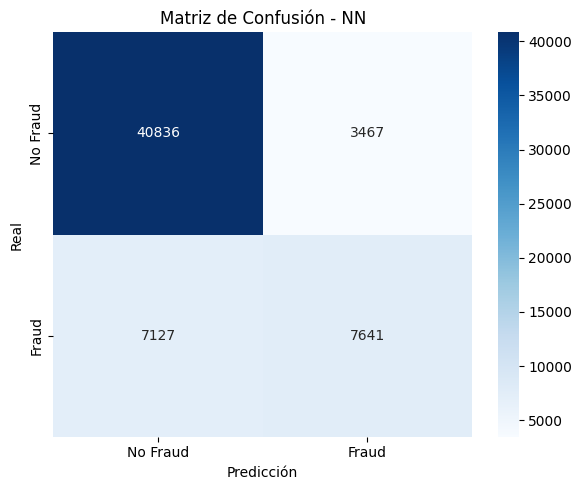

In [205]:
# Etiquetas de clase
labels = ["No Fraud", "Fraud"]

# Crear visualización estilo subplot
plt.figure(figsize=(6, 5))  # Ajusta tamaño si hay más subplots

plt.subplot(1, 1, 1)  # Cambiar a (4, 3, i) si tienes muchas
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)

plt.title("Matriz de Confusión - NN")
plt.xlabel("Predicción")
plt.ylabel("Real")

plt.tight_layout()
plt.show()

In [176]:
tn, fp, fn, tp = cm.ravel()
fpr_nn = fp / (fp + tn)

results_nn = {
    "Accuracy": report_nn["accuracy"],
    "Precision fraude": report_nn["1"]["precision"],
    "Precision legitimo": report_nn["0"]["precision"],
    "Recall fraude": report_nn["1"]["recall"],
    "Recall legitimo": report_nn["0"]["recall"],
    "F1-score fraude": report_nn["1"]["f1-score"],
    "F1-score legitimo": report_nn["0"]["f1-score"],
    "ROC AUC": roc_auc_score(y_test, y_pred_proba), # Calculate ROC AUC separately
    "FP-Rate": fpr_nn
}

In [177]:
# Convertir a DataFrame con índice como nombre del modelo
df_nn = pd.DataFrame(results_nn, index=["Red Neuronal"])
print(df_nn)

              Accuracy  Precision fraude  Precision legitimo  Recall fraude  \
Red Neuronal  0.820656          0.687883            0.851406       0.517402   

              Recall legitimo  F1-score fraude  F1-score legitimo  ROC AUC  \
Red Neuronal         0.921743         0.590586            0.88518  0.81523   

               FP-Rate  
Red Neuronal  0.078257  


In [178]:
y_pred_proba = y_pred_proba.ravel()
predicciones_nn_df = pd.DataFrame({
    "y_real": y_test,
    "y_pred": y_pred.flatten()
})
probabilidades_nn_df = pd.DataFrame({
    "y_real": y_test,
    "probabilidad_fraude": y_pred_proba
})

In [170]:
# Guardar en un solo archivo Excel con varias hojas
with pd.ExcelWriter("resultados_red_neuronal.xlsx") as writer:
    df_nn.to_excel(writer, sheet_name="Resumen métricas")
    predicciones_nn_df.to_excel(writer, sheet_name="Predicciones")
    probabilidades_nn_df.to_excel(writer, sheet_name="Probabilidades")

print("Archivo 'resultados_red_neuronal.xlsx' guardado con éxito.")

Archivo 'resultados_red_neuronal.xlsx' guardado con éxito.


#4.Ensamble

In [180]:
#Unir los mejores resultados.

results_pre = pd.concat([results_df, df_nn]).round(3)
results_pre

,Accuracy,Precision fraude,Precision legitimo,Recall fraude,Recall legitimo,F1-score fraude,F1-score legitimo,ROC AUC,FP-Rate
Regresión Logística,0.687,0.422,0.866,0.680,0.690,0.521,0.768,0.752,0.310
Árbol de Decisión,0.827,0.783,0.834,0.428,0.960,0.554,0.893,0.815,0.040
Random Forest,0.827,0.811,0.829,0.400,0.969,0.535,0.893,0.812,0.031
Naive Bayes,0.801,0.737,0.808,0.315,0.963,0.442,0.879,0.771,0.038
Gradient Boosting,0.828,0.775,0.836,0.437,0.958,0.559,0.893,0.817,0.042
AdaBoost,0.825,0.757,0.837,0.443,0.953,0.559,0.891,0.810,0.048
Bagging,0.822,0.767,0.831,0.415,0.958,0.539,0.890,0.798,0.042
XGBoost,0.828,0.788,0.834,0.427,0.962,0.553,0.893,0.817,0.038
LightGBM,0.828,0.786,0.834,0.427,0.961,0.553,0.893,0.817,0.039
Red Neuronal,0.821,0.688,0.851,0.517,0.922,0.591,0.885,0.815,0.078


In [193]:
predicciones = predicciones.drop(columns=["Regresión Logística"])
predicciones["Red neuronal"] = predicciones_nn_df["y_pred"]
predicciones.head()

,Real,Árbol de Decisión,Random Forest,Naive Bayes,Gradient Boosting,AdaBoost,Bagging,XGBoost,LightGBM,Red neuronal,Voting
181345,0,0,0,0,0,0,0,0,0,0,0
286871,0,0,0,0,0,0,0,0,0,0,0
246589,0,0,0,0,0,0,0,0,0,0,0
222189,0,0,0,0,0,0,0,0,0,0,0
107829,0,0,0,0,0,0,0,0,0,0,0


In [194]:
#Voting según la moda
predicciones["Voting"] = predicciones.mode(axis=1)[0]

In [202]:
# Calcular el reporte
report_voting = classification_report(y_test, predicciones["Voting"], output_dict=True)

# Calcular probabilidades si no las tienes (usamos predicciones binarias como proxy)

# Matriz de confusión para calcular tasa de falsos positivos
cm_ensamble = confusion_matrix(y_test, predicciones["Voting"])
tn, fp, fn, tp = cm_ensamble.ravel()
fpr_voting = fp / (fp + tn)

# Diccionario con métricas del ensamble por votación
results_voting = {
    "Accuracy": report_voting["accuracy"],
    "Precision fraude": report_voting["1"]["precision"],
    "Precision legitimo": report_voting["0"]["precision"],
    "Recall fraude": report_voting["1"]["recall"],
    "Recall legitimo": report_voting["0"]["recall"],
    "F1-score fraude": report_voting["1"]["f1-score"],
    "F1-score legitimo": report_voting["0"]["f1-score"],
    "ROC AUC": roc_auc_score(y_test, y_pred_proba),
    "FP-Rate": fpr_voting
}

df_ensamble = pd.DataFrame(results_voting, index=["Ensamble"])

In [196]:
results_fin = pd.concat([results_pre, df_ensamble]).round(3)
results_fin

,Accuracy,Precision fraude,Precision legitimo,Recall fraude,Recall legitimo,F1-score fraude,F1-score legitimo,ROC AUC,FP-Rate
Regresión Logística,0.687,0.422,0.866,0.680,0.690,0.521,0.768,0.752,0.310
Árbol de Decisión,0.827,0.783,0.834,0.428,0.960,0.554,0.893,0.815,0.040
Random Forest,0.827,0.811,0.829,0.400,0.969,0.535,0.893,0.812,0.031
Naive Bayes,0.801,0.737,0.808,0.315,0.963,0.442,0.879,0.771,0.038
Gradient Boosting,0.828,0.775,0.836,0.437,0.958,0.559,0.893,0.817,0.042
AdaBoost,0.825,0.757,0.837,0.443,0.953,0.559,0.891,0.810,0.048
Bagging,0.822,0.767,0.831,0.415,0.958,0.539,0.890,0.798,0.042
XGBoost,0.828,0.788,0.834,0.427,0.962,0.553,0.893,0.817,0.038
LightGBM,0.828,0.786,0.834,0.427,0.961,0.553,0.893,0.817,0.039
Red Neuronal,0.821,0.688,0.851,0.517,0.922,0.591,0.885,0.815,0.078


In [192]:
results_fin = pd.concat([results_pre, df_ensamble]).round(3)
results_fin

,Accuracy,Precision fraude,Precision legitimo,Recall fraude,Recall legitimo,F1-score fraude,F1-score legitimo,ROC AUC,FP-Rate
Regresión Logística,0.687,0.422,0.866,0.680,0.690,0.521,0.768,0.752,0.310
Árbol de Decisión,0.827,0.783,0.834,0.428,0.960,0.554,0.893,0.815,0.040
Random Forest,0.827,0.811,0.829,0.400,0.969,0.535,0.893,0.812,0.031
Naive Bayes,0.801,0.737,0.808,0.315,0.963,0.442,0.879,0.771,0.038
Gradient Boosting,0.828,0.775,0.836,0.437,0.958,0.559,0.893,0.817,0.042
AdaBoost,0.825,0.757,0.837,0.443,0.953,0.559,0.891,0.810,0.048
Bagging,0.822,0.767,0.831,0.415,0.958,0.539,0.890,0.798,0.042
XGBoost,0.828,0.788,0.834,0.427,0.962,0.553,0.893,0.817,0.038
LightGBM,0.828,0.786,0.834,0.427,0.961,0.553,0.893,0.817,0.039
Red Neuronal,0.821,0.688,0.851,0.517,0.922,0.591,0.885,0.815,0.078


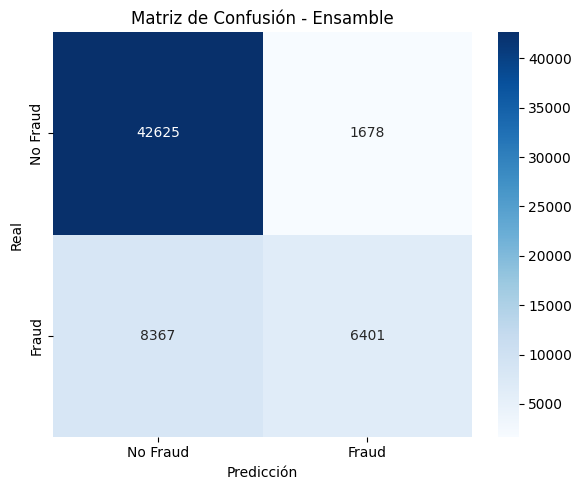

In [203]:
# Etiquetas de clase
labels = ["No Fraud", "Fraud"]

# Crear visualización estilo subplot
plt.figure(figsize=(6, 5))  # Ajusta tamaño si hay más subplots

plt.subplot(1, 1, 1)  # Cambiar a (4, 3, i) si tienes muchas
sns.heatmap(cm_ensamble, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)

plt.title("Matriz de Confusión - Ensamble")
plt.xlabel("Predicción")
plt.ylabel("Real")

plt.tight_layout()
plt.show()